In [1]:
!pip install mesa==1.2.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from scipy.stats import ttest_ind, f_oneway, chi2_contingency, spearmanr

from experiments import (
    SCENARIOS,
    run_all_scenarios,
    H1a_test, H1b_test, H1c_test,
    H2a_test, H2b_test,
    H3a_test, H3b_test,
    save_results,
)

from analysis import(
    hft_aggression,
    price_inefficiency,
    tail_events,
    compute_rv,
    implied_vol_proxy,
    iv_rv_gap
)


# Get performance for various scenarios


Scenarios:
1) Baseline
2) With only market-makers (MM)
3) only HFT present on the market
4) HFT + MM

In [4]:
SEEDS = range(30)

data = run_all_scenarios(
    scenarios=SCENARIOS,
    seeds=SEEDS,
    T=2000
)

# Prepare data for testing hypotheses

## For Hypothesis 1

H1a: Impact of HFT on Short-Term Price Discovery

In [5]:
dfs_no_hft = data["no_hft_no_mm"]["dfs"]
dfs_hft = data["hft_only"]["dfs"]
dfs_hft_mm = data["hft_mm"]["dfs"]

H1b: Endogenous Volatility Effects

Groups are needed for ANOVA

In [6]:
groups = {
    "no_hft": dfs_no_hft,
    "hft": dfs_hft,
    "hft_mm": dfs_hft_mm
}

H1c: Tail Risk and Extreme Price Movements

Does not require any new movements

## For Hypothesis 2

H2a: Aggressive Trading by HFT in High-Volatility Regimes

In [7]:
aggr_hi, aggr_lo = [], []

for dfs, trades in zip(
    data["hft_mm"]["dfs"],
    data["hft_mm"]["trades"]
):
    mid = dfs["mid"].values
    rets = np.diff(np.log(mid))
    vol = np.abs(rets)

    hi, lo = hft_aggression(trades, vol)
    aggr_hi.append(hi)
    aggr_lo.append(lo)

aggr_hi = np.array(aggr_hi)
aggr_lo = np.array(aggr_lo)


H2b: Short-Term Price Impact of Aggressive HFT Trading

In [8]:
rets_all = []
aggr_all = []

for dfs, trades in zip(
    data["hft_only"]["dfs"],
    data["hft_only"]["trades"]
):
    mid = dfs["mid"].values
    rets = np.abs(np.diff(np.log(mid)))

    aggression = trades["price"].isna().astype(int).values[:len(rets)]

    rets_all.append(rets)
    aggr_all.append(aggression)

rets = np.concatenate(rets_all)
aggression = np.concatenate(aggr_all)


## For Hypothesis 3

H3a: Divergence Between Implied and Realized Volatility

In [9]:
rv = np.array([
    compute_rv(df) for df in dfs_hft_mm
])

mm_inventory = np.array([
    df["mm_inventory"].values for df in dfs_hft_mm
])

iv = np.array([
    implied_vol_proxy(inv).mean()
    for inv in mm_inventory
])

gap = iv_rv_gap(iv, rv)


stress / normal

In [10]:
thr = np.quantile(rv, 0.75)

gap_stress  = gap[rv > thr]
gap_normal  = gap[rv <= thr]


H3b: Volatility Distortions and Agent Activity

In [11]:
activity = np.array([
    len(tr) for tr in data["hft_mm"]["trades"]
])


# Results of testing hypotheses

In [12]:
results = []

results.append(H1a_test(dfs_hft, dfs_no_hft))
results.append(H1b_test(groups))
results.append(H1c_test(dfs_hft_mm, dfs_no_hft))
results.append(H2a_test(aggr_hi, aggr_lo))
results.append(H2b_test(rets, aggression))
results.append(H3a_test(gap_stress, gap_normal))
results.append(H3b_test(gap, activity))

df_results = save_results(results)
df_results


,hypothesis,test,rationale,statistic,p_value,alpha,reject_H0,mean_HFT,mean_no_HFT,mean_no_hft,mean_hft,mean_hft_mm,mean_high_vol,mean_low_vol
0,H1a: Price discovery improves with HFT,t-test,Comparison of mean price inefficiency; CLT jus...,-17.882483,1.005592e-71,0.05,True,0.071656,0.079366,NaN,NaN,NaN,NaN,NaN
1,H1b: Volatility increases with HFT and options,ANOVA,Comparison of mean realized volatility across ...,564.296750,1.516329e-50,0.05,True,NaN,NaN,0.034159,0.039984,0.039257,NaN,NaN
2,H1c: Tail risk increases with HFT and options,Chi-squared,Extreme events are binary outcomes; test compa...,8.303517,3.956838e-03,0.05,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H2a: HFT aggression increases in high volatili...,t-test,Comparison of mean aggressive order share acro...,5.508621,1.232531e-06,0.05,True,NaN,NaN,NaN,NaN,NaN,0.511098,0.505353
4,H2b: Aggressive HFT amplifies short-term price...,OLS (t-test on β),Linear regression tests marginal effect of agg...,0.000000,NaN,0.05,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H3a: IV–RV gap increases in stress regimes,Welch t-test,Comparison of mean IV–RV gap across regimes wi...,6.111072,2.808353e-06,0.05,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,H3b: IV–RV gap correlates with agent activity,Spearman correlation,Monotonic relationship without assuming linearity,0.038487,8.399790e-01,0.05,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizations

### H1a — Price discovery

The plot below shows the dynamics of the market price relative to the fundamental value over time for a single typical simulation run.

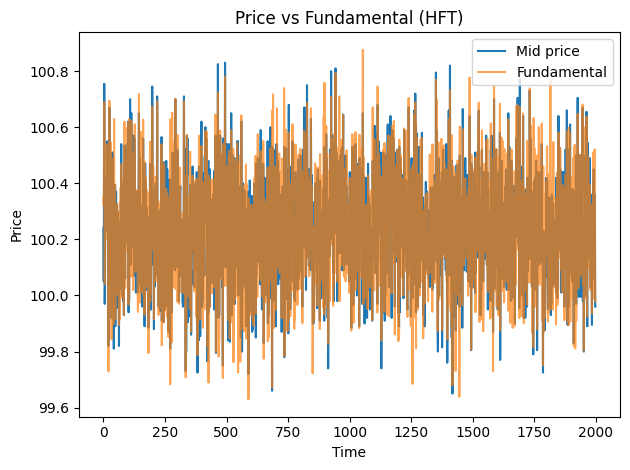

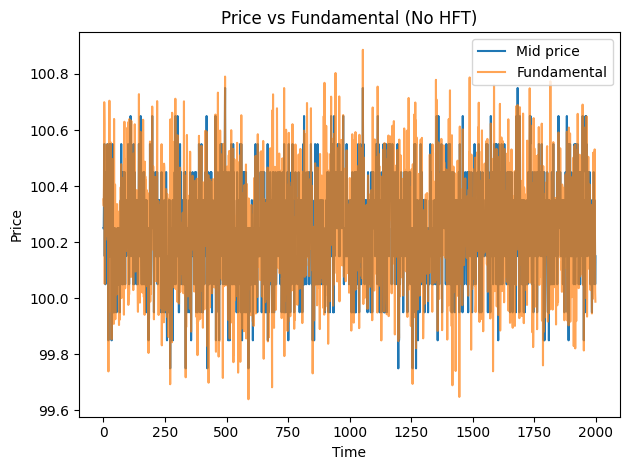

In [13]:
from visualization import plot_price_vs_fundamental, plot_price_inefficiency_dist

df_hft = data["hft_only"]["dfs"][0]
df_no = data["no_hft_no_mm"]["dfs"][0]

fig = plot_price_vs_fundamental(
    df_hft,
    title="Price vs Fundamental (HFT)"
)
plt.show()

fig = plot_price_vs_fundamental(
    df_no,
    title="Price vs Fundamental (No HFT)"
)
plt.show()


The market price $P_t$ is  formed through agent interactions, while the fundamental value $F_t$ follows an stochastic process.

In markets with HFT participation, prices track the fundamental value more closely and adjust more rapidly following deviations. In contrast, in the absence of HFT agents, price deviations are more persistent and convergence to fundamentals is slower.

The actual proof for this hypothesis is price inefficiency

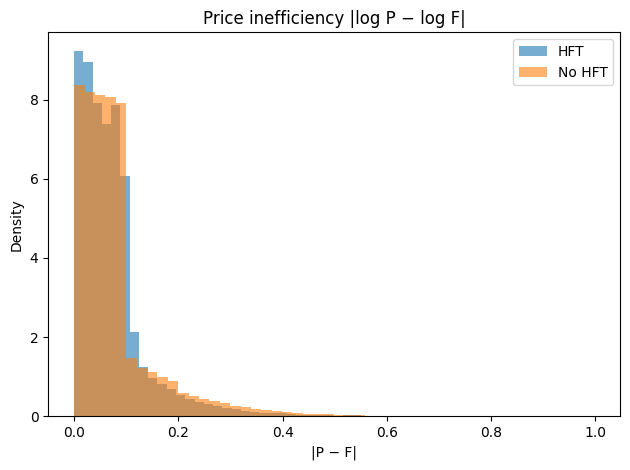

In [14]:
ineff_hft = np.concatenate([
    price_inefficiency(df) for df in data["hft_only"]["dfs"]
])

ineff_no = np.concatenate([
    price_inefficiency(df) for df in data["no_hft_no_mm"]["dfs"]
])

fig = plot_price_inefficiency_dist(
    ineff_hft,
    ineff_no,
    labels=("HFT", "No HFT"),
    title="Price inefficiency |log P − log F|"
)
plt.show()


The distribution for markets with HFT is shifted toward lower values and exhibits a thinner right tail relative to the scenario with no HFT. Both the mean and median price inefficiency are lower in the presence of HFT, indicating that prices remain closer to fundamental values. This visual evidence is consistent with the results of the t-test, supporting improved short-term price discovery in markets with HFT participation.

### H1b — Endogenous volatility

Consider how the shape of return distributions changes in the presence of HFT and market-making activity.

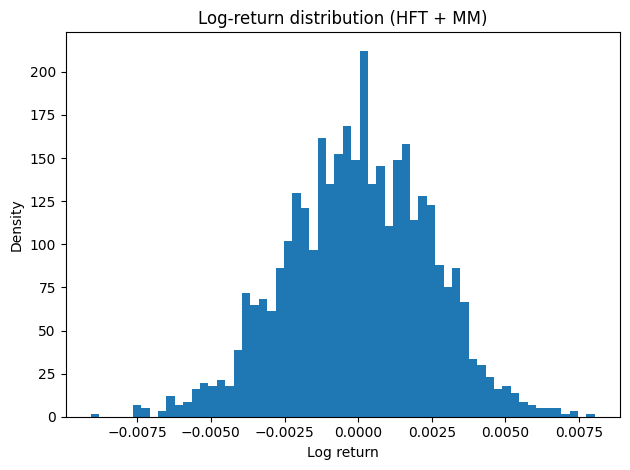

In [15]:
from visualization import plot_return_histogram

fig = plot_return_histogram(
    data["hft_mm"]["dfs"][0],
    title="Log-return distribution (HFT + MM)"
)
plt.show()


While the return distribution remains sharply peaked around zero, markets with HFT exhibit heavier tails, indicating a higher probability of extreme price movements.

So, the volatility arises from agent interactions rather than from exogenous shocks alone.

Consider realized volatility comparison across market configurations:

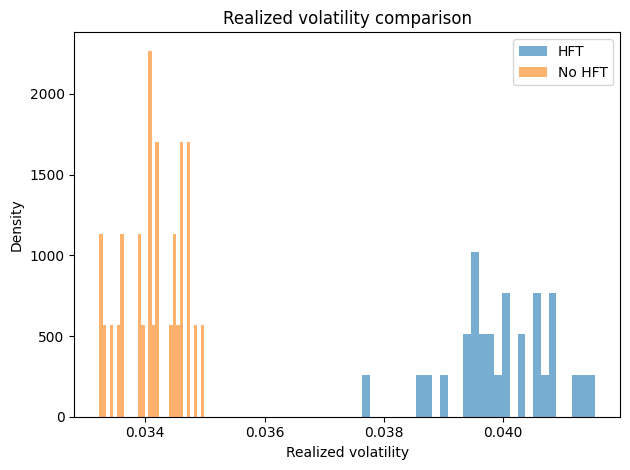

In [16]:
from visualization import plot_volatility_comparison

rv_hft = np.array([
    compute_rv(df) for df in data["hft_only"]["dfs"]
])

rv_no = np.array([
    compute_rv(df) for df in data["no_hft_no_mm"]["dfs"]
])

fig = plot_volatility_comparison(
    rv_hft,
    rv_no,
    labels=("HFT", "No HFT"),
    title="Realized volatility comparison"
)
plt.show()


This figure provides a visual confirmation of the ANOVA results used to test the hypothesis: there's higher average volatility in markets with HFT compared to the ones lacking them. Moreover, volatility distibutions do not intersect on the plot, showing that the impact of HFT is essential.

### H1c — Tail Risk and Extreme Price Movements

Cumulative distribution function (CCDF) directly captures the likelihood of extreme price movements, so let's look at it.

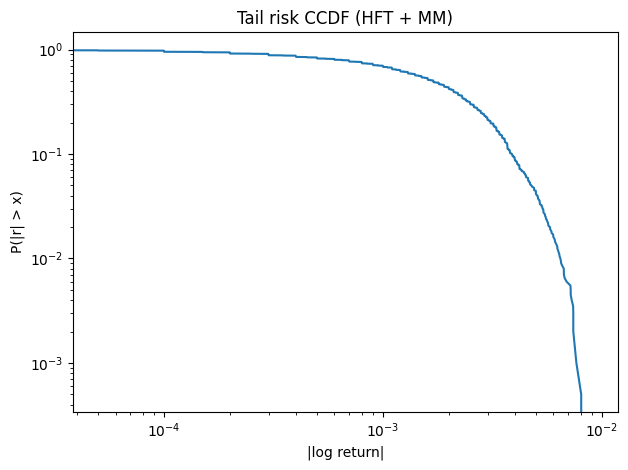

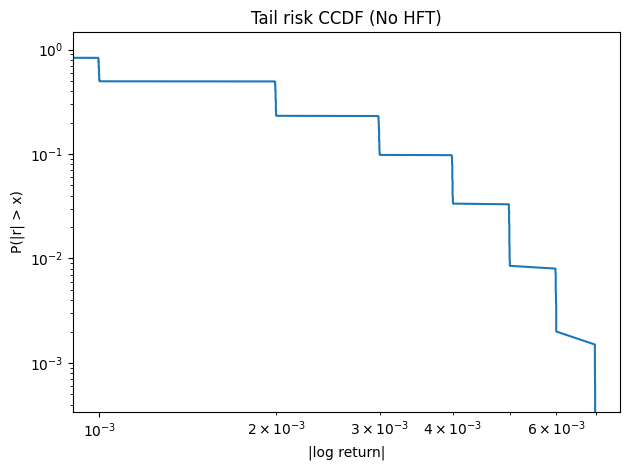

In [17]:
from visualization import plot_tail_ccdf

fig = plot_tail_ccdf(
    data["hft_mm"]["dfs"][0],
    title="Tail risk CCDF (HFT + MM)"
)
plt.show()

fig = plot_tail_ccdf(
    data["no_hft_no_mm"]["dfs"][0],
    title="Tail risk CCDF (No HFT)"
)
plt.show()


There is slower decay of the CCDF in markets with HFT and option-related strategies. Moreover, the tails are thicker compared to the scenario with no HFT.

So, there is elevated tail risk in markets with HFT and option-related activity, supporting the results of the chi-squared tests.

### H2a: Aggressive Trading in High-Volatility Regimes

Consider whether agents increase the share of aggressive orders during periods of elevated volatility.

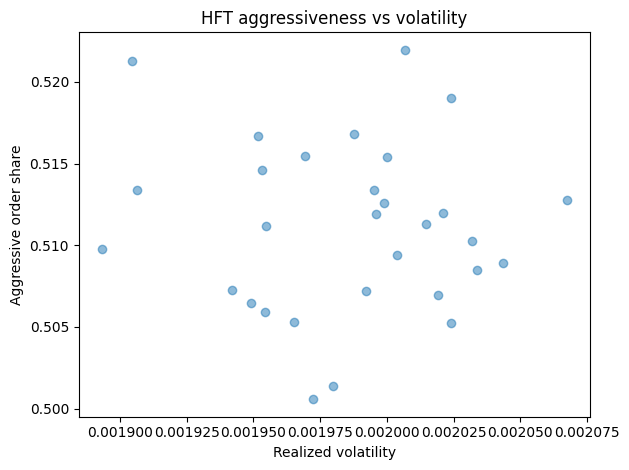

In [18]:
from visualization import plot_aggressiveness_vs_volatility

vols = []
aggr = []

for df, tr in zip(
    data["hft_mm"]["dfs"],
    data["hft_mm"]["trades"]
):
    mid = df["mid"].values
    rets = np.diff(np.log(mid))
    vol = np.abs(rets)

    hi, lo = hft_aggression(tr, vol)
    vols.append(np.mean(vol))
    aggr.append(hi)

fig = plot_aggressiveness_vs_volatility(
    np.array(vols),
    np.array(aggr),
    title="HFT aggressiveness vs volatility"
)
plt.show()


We can see that higher aggressiveness is concentrated in high-volatility regimes. It indicates that HFT agents adapt their strategies to market conditions, increasing the use of aggressive orders during periods of elevated volatility.

### H2b — Short-Term Price Impact of Aggressive Trading

For this we compare agressive and baseline trading

In [19]:
def compute_price_impact(df, trades):
    mid = df["mid"].astype(float).values
    rets = np.diff(np.log(mid))

    trades = trades.dropna(subset=["t"])

    abs_ret_aggr = []
    abs_ret_base = []

    for _, tr in trades.iterrows():
        t = int(tr["t"])
        if t <= 0 or t >= len(rets):
            continue

        abs_ret = abs(rets[t])

        if tr["is_aggressive"]:
            abs_ret_aggr.append(abs_ret)
        else:
            abs_ret_base.append(abs_ret)

    return np.array(abs_ret_aggr), np.array(abs_ret_base)


In [20]:
abs_ret_aggr_all = []
abs_ret_base_all = []

for df, tr in zip(
    data["hft_mm"]["dfs"],
    data["hft_mm"]["trades"]
):
    a, b = compute_price_impact(df, tr)
    abs_ret_aggr_all.append(a)
    abs_ret_base_all.append(b)

abs_ret_aggr = np.concatenate(abs_ret_aggr_all)
abs_ret_base = np.concatenate(abs_ret_base_all)


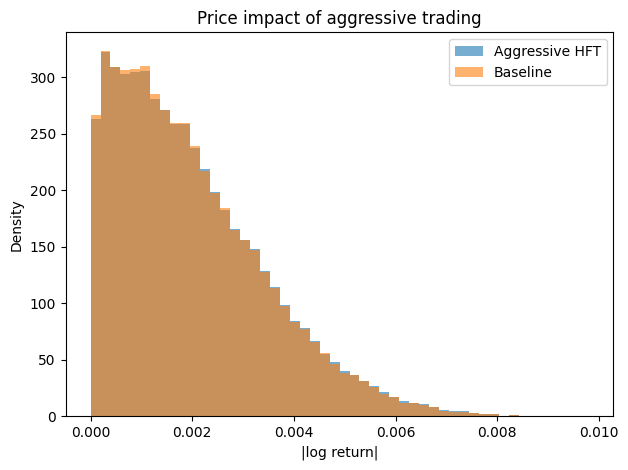

In [21]:
from visualization import plot_price_impact_comparison

fig = plot_price_impact_comparison(
    abs_ret_aggr,
    abs_ret_base,
    labels=("Aggressive HFT", "Baseline"),
    title="Price impact of aggressive trading"
)
plt.show()


Both agressive and baseline trades are associated with larger immediate price changes, as evidenced by a rightward shift in the distribution.

We can conclude that not only aggressive HFT trading amplify short-term price movements for our model.

### H3a — Implied vs. Realized Volatility Gap

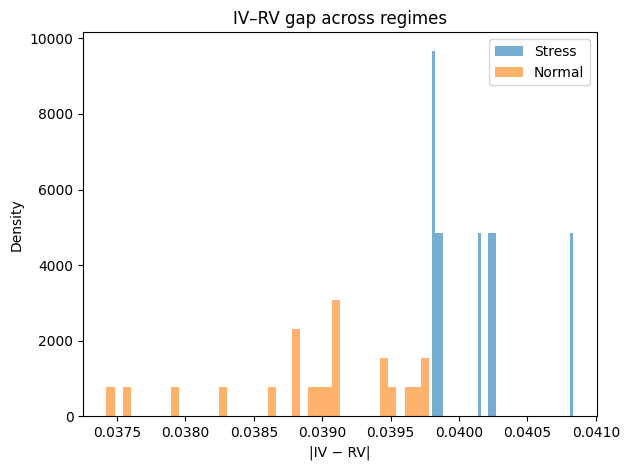

In [22]:
from visualization import plot_iv_rv_gap_distribution

fig = plot_iv_rv_gap_distribution(
    gap_stress,
    gap_normal,
    labels=("Stress", "Normal"),
    title="IV–RV gap across regimes"
)
plt.show()


There are larger implied–realized volatility gaps in stress regimes, which implies that volatility expectations deteriorate during stress periods.

It is thus implied volatility becomes less informative during periods of market stress.

### H3b — Volatility Distortions and Agent Activity

Let's to see if there is link between them

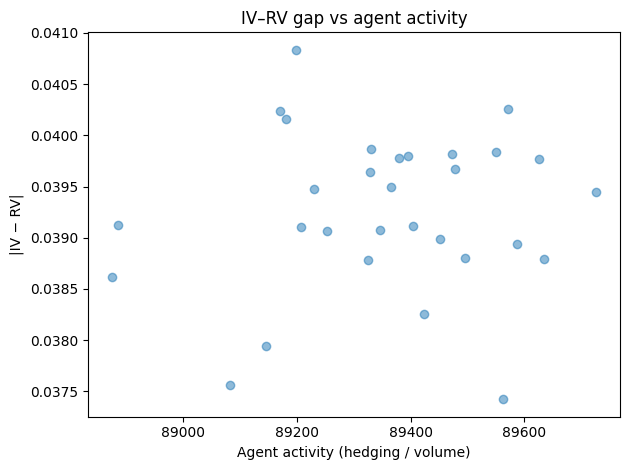

In [23]:
from visualization import plot_gap_vs_activity

fig = plot_gap_vs_activity(
    activity,
    gap,
    title="IV–RV gap vs agent activity"
)
plt.show()


We can see that there is a positive association between agent activity and the IV–RV gap. This indicated that volatility distortions are linked to the behavior of HFT and option-oriented agents.